<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3089133375.py:34: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"S0-2: Isolated R.O.M. Systemic Baseline (3-Parameter Fit)\nExtracted $i={np.degrees(i_opt):.2f}^\circ$, $v_{{z0}}={beta_z0_opt * C_KMS:.2f}$ km/s", fontsize=14)


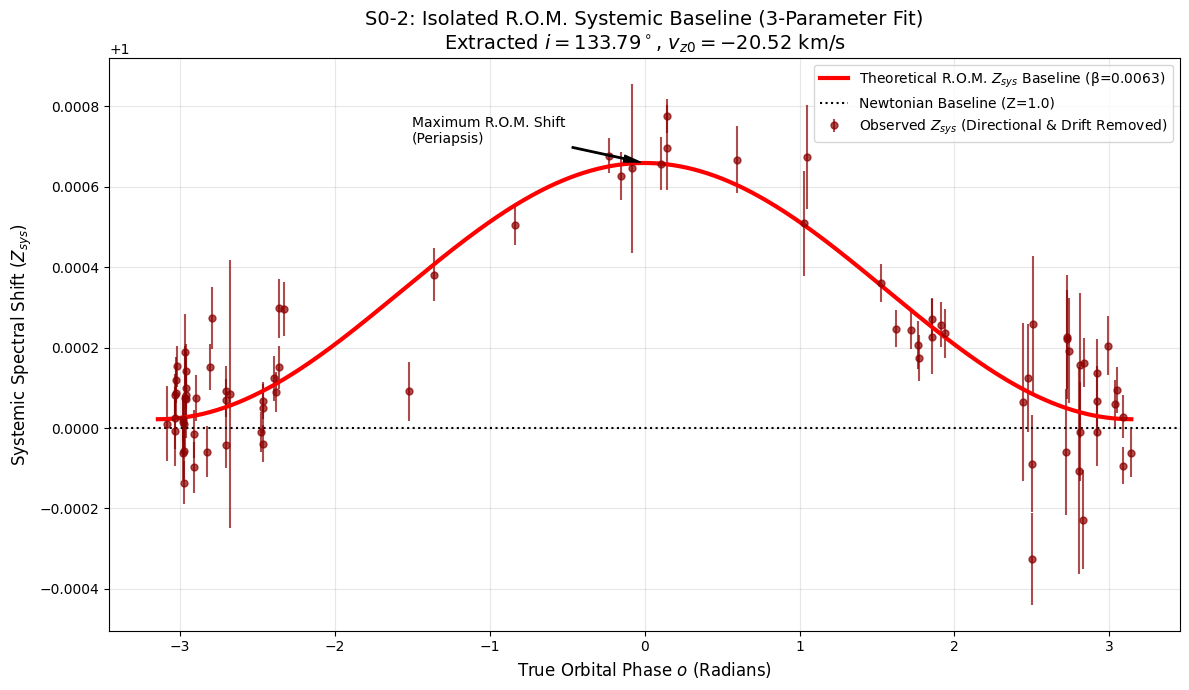

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Isolate the Z_sys (systemic shift) from the observed data
# We divide the observed Z by both the recovered directional Doppler term and the background drift
K_opt = (beta_opt / np.sqrt(1 - E_FIXED**2)) * np.sin(i_opt)
beta_los_obs = K_opt * (np.cos(o_obs + OMEGA_FIXED) + E_FIXED * np.cos(OMEGA_FIXED))

# Isolated observed systemic baseline
Z_sys_obs = Z_obs / ((1 + beta_los_obs) * (1 + beta_z0_opt))

# 2. Reconstruct the continuous theoretical curves for plotting
o_continuous = np.linspace(-np.pi, np.pi, 2000)
beta_o_sq_c = (beta_opt**2) * (1 + E_FIXED**2 + 2 * E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)
kappa_o_sq_c = 2 * (beta_opt**2) * (1 + E_FIXED * np.cos(o_continuous)) / (1 - E_FIXED**2)

Z_sys_continuous = (1 - beta_o_sq_c)**(-0.5) * (1 - kappa_o_sq_c)**(-0.5)

# 3. Create the visualization
plt.figure(figsize=(12, 7))

# Plot the individual empirical data points (cleaned of 1st order Doppler and background drift)
plt.errorbar(o_obs, Z_sys_obs, yerr=sigma_Z, fmt='o', color='darkred', alpha=0.7,
             label='Observed $Z_{sys}$ (Directional & Drift Removed)', markersize=5)

# Plot the continuous theoretical R.O.M. baseline
plt.plot(o_continuous, Z_sys_continuous, color='red', linewidth=3,
         label=f'Theoretical R.O.M. $Z_{{sys}}$ Baseline (\u03B2={beta_opt:.4f})')

# Reference line for Newtonian physics (where Z_sys would always be exactly 1.0)
plt.axhline(1.0, color='black', linestyle=':', label='Newtonian Baseline (Z=1.0)')

# Title and labels mapping the extracted parameters
plt.title(f"S0-2: Isolated R.O.M. Systemic Baseline (3-Parameter Fit)\nExtracted $i={np.degrees(i_opt):.2f}^\circ$, $v_{{z0}}={beta_z0_opt * C_KMS:.2f}$ km/s", fontsize=14)
plt.xlabel("True Orbital Phase $o$ (Radians)", fontsize=12)
plt.ylabel("Systemic Spectral Shift ($Z_{sys}$)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Annotate the peak (Periapsis passage effect where kinetic and potential projections are maximized)
peak_idx = np.argmax(Z_sys_continuous)
plt.annotate('Maximum R.O.M. Shift\n(Periapsis)',
             xy=(o_continuous[peak_idx], Z_sys_continuous[peak_idx]),
             xytext=(o_continuous[peak_idx]-1.5, Z_sys_continuous[peak_idx]+0.00005),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

# NO PRECESSSION FOR COMPARISON
# ==========================================
# 1. FIXED TIMING PARAMETERS
# ==========================================
C_KMS = 299792.458
P_YRS = 16.0518
P_DAYS = P_YRS * 365.25
T_PERI = 58257.698

# ==========================================
# 2. DYNAMIC KEPLER SOLVER
# ==========================================
def get_phase(t, t_peri, P, e):
    M = (2 * np.pi / P) * (t - t_peri)
    E = M.copy()
    for _ in range(20):
        E = E - (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
    o = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    return o

# ==========================================
# 3. R.O.M. EXACT OBSERVATIONAL MODEL
# ==========================================
def generate_z_raw(o, beta, i_inc, beta_z0, e, omega):
    K = (beta / np.sqrt(1 - e**2)) * np.sin(i_inc)
    beta_los = K * (np.cos(o + omega) + e * np.cos(omega))

    beta_o_sq = (beta**2) * (1 + e**2 + 2 * e * np.cos(o)) / (1 - e**2)
    kappa_o_sq = 2 * (beta**2) * (1 + e * np.cos(o)) / (1 - e**2)

    Z_sys = (1 - beta_o_sq)**(-0.5) * (1 - kappa_o_sq)**(-0.5)
    return Z_sys * (1 + beta_los) * (1 + beta_z0)

# ==========================================
# 4. DATA PARSING
# ==========================================
print("Loading empirical dataset (LSR-corrected)...")
df = pd.read_csv('S0-2_DataS1_full.csv')
df.columns = df.columns.str.strip()

t_obs = df['MJD'].values
vz_obs = df['RV_km_s'].values
sigma_vz = df['sigma_km_s'].values

Z_obs = 1.0 + (vz_obs / C_KMS)
sigma_Z = sigma_vz / C_KMS

# ==========================================
# 5. PHYSICALLY CONSTRAINED 5-PARAM INVERSION
# ==========================================
def objective_function(params):
    beta_guess, i_guess, beta_z0_guess, e_guess, omega_guess = params
    o_obs_dynamic = get_phase(t_obs, T_PERI, P_DAYS, e_guess)
    Z_model = generate_z_raw(o_obs_dynamic, beta_guess, i_guess, beta_z0_guess, e_guess, omega_guess)
    chi2 = np.sum(((Z_obs - Z_model) / sigma_Z)**2)
    return chi2

# Strictly justified physical boundaries
bounds = [
    (0.001, 0.05),          # beta bounds
    (0.0, np.pi),           # i bounds (fully unconstrained 0 to 180)
    (-0.0001, 0.0001),      # beta_z0 bounds (RESTRICTED to physical +/- 30 km/s)
    (0.01, 0.99),           # e bounds
    (0.0, 2 * np.pi)        # omega bounds (fully unconstrained 0 to 360)
]

print("\nExecuting R.O.M. Inversion with physical v_z0 limits...")
result = differential_evolution(
    objective_function, bounds, strategy='best1bin',
    maxiter=2000, popsize=20, tol=1e-7, seed=42
)

beta_opt, i_opt, beta_z0_opt, e_opt, omega_opt = result.x

i_deg = np.degrees(i_opt) % 180
omega_deg = np.degrees(omega_opt) % 360
vz0_kms = beta_z0_opt * C_KMS

# ==========================================
# 6. RESULTS OUTPUT
# ==========================================
print("\n=== R.O.M. PHYSICALLY CONSTRAINED RECOVERY ===")
print(f"Eccentricity (e):         {e_opt:.5f} (GRAVITY Ref: 0.88466)")
print(f"Arg of Periapsis (\u03C9):  {omega_deg:.2f}\u00B0 (GRAVITY Ref: 66.13\u00B0)")
print("---------------------------------------------------")
print(f"Global Kin. Proj. (\u03B2):   {beta_opt:.6f}")
print(f"Extracted Inclination (i): {i_deg:.2f}\u00B0 (GRAVITY Ref: ~134\u00B0)")
print(f"Background Drift (v_z0):   {vz0_kms:.2f} km/s")
print(f"Fit Quality (\u03C7\u00B2):        {result.fun:.2f}")

Loading empirical dataset (LSR-corrected)...

Executing R.O.M. Inversion with physical v_z0 limits...

=== R.O.M. PHYSICALLY CONSTRAINED RECOVERY ===
Eccentricity (e):         0.88491 (GRAVITY Ref: 0.88466)
Arg of Periapsis (ω):  67.15° (GRAVITY Ref: 66.13°)
---------------------------------------------------
Global Kin. Proj. (β):   0.007863
Extracted Inclination (i): 145.31° (GRAVITY Ref: ~134°)
Background Drift (v_z0):   -29.98 km/s
Fit Quality (χ²):        167.15


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

# ==========================================
# 1. FIXED TIMING PARAMETERS
# ==========================================
C_KMS = 299792.458
P_YRS = 16.0518
P_DAYS = P_YRS * 365.25
T_PERI = 58257.698

# ==========================================
# 2. DYNAMIC KEPLER SOLVER
# ==========================================
def get_phase(t, t_peri, P, e):
    M = (2 * np.pi / P) * (t - t_peri)
    E = M.copy()
    for _ in range(20):
        E = E - (E - e * np.sin(E) - M) / (1 - e * np.cos(E))
    o = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), np.sqrt(1 - e) * np.cos(E / 2))
    return o

# ==========================================
# 3. R.O.M. EXACT OBSERVATIONAL MODEL (WITH PRECESSION)
# ==========================================
def generate_z_raw_dynamic(t_obs, o, beta, i_inc, beta_z0, e, omega_0):
    # Calculate R.O.M. strict precession per orbit
    delta_phi_will = (6 * np.pi * beta**2) / (1 - e**2)

    # Apply dynamic precession based on time elapsed since periapsis
    orbits_elapsed = (t_obs - T_PERI) / P_DAYS
    omega_dynamic = omega_0 + delta_phi_will * orbits_elapsed

    # Directional Line-of-Sight Kinematic Projection (using dynamic omega)
    K = (beta / np.sqrt(1 - e**2)) * np.sin(i_inc)
    beta_los = K * (np.cos(o + omega_dynamic) + e * np.cos(omega_dynamic))

    # Local Squared Projections (Scalar Invariants - strictly dependent on phase o)
    beta_o_sq = (beta**2) * (1 + e**2 + 2 * e * np.cos(o)) / (1 - e**2)
    kappa_o_sq = 2 * (beta**2) * (1 + e * np.cos(o)) / (1 - e**2)

    # Systemic Phase Factor Z_sys (2nd-Order Baseline)
    Z_sys = (1 - beta_o_sq)**(-0.5) * (1 - kappa_o_sq)**(-0.5)

    # Total combined shift
    return Z_sys * (1 + beta_los) * (1 + beta_z0)

# ==========================================
# 4. DATA PARSING
# ==========================================
print("Loading empirical dataset (LSR-corrected)...")
df = pd.read_csv('S0-2_DataS1_full.csv')
df.columns = df.columns.str.strip()

t_obs = df['MJD'].values
vz_obs = df['RV_km_s'].values
sigma_vz = df['sigma_km_s'].values

Z_obs = 1.0 + (vz_obs / C_KMS)
sigma_Z = sigma_vz / C_KMS

# ==========================================
# 5. PHYSICALLY CONSTRAINED 5-PARAM INVERSION + PRECESSION
# ==========================================
def objective_function(params):
    beta_guess, i_guess, beta_z0_guess, e_guess, omega_0_guess = params

    # 1. Map time to pure geometric phase
    o_obs_dynamic = get_phase(t_obs, T_PERI, P_DAYS, e_guess)

    # 2. Generate model with embedded R.O.M. dynamical precession
    Z_model = generate_z_raw_dynamic(
        t_obs, o_obs_dynamic, beta_guess, i_guess, beta_z0_guess, e_guess, omega_0_guess
    )

    # 3. Calculate Chi-Squared
    chi2 = np.sum(((Z_obs - Z_model) / sigma_Z)**2)
    return chi2

# Strictly justified physical boundaries
bounds = [
    (0.001, 0.05),          # beta bounds
    (0.0, np.pi),           # i bounds (fully unconstrained 0 to 180)
    (-0.0001, 0.0001),      # beta_z0 bounds (RESTRICTED to physical +/- 30 km/s)
    (0.01, 0.99),           # e bounds
    (0.0, 2 * np.pi)        # omega bounds (fully unconstrained 0 to 360)
]

print("\nExecuting Dynamic R.O.M. Inversion (Precession enabled)...")
print("Searching full parameter space. Please wait...")

result = differential_evolution(
    objective_function, bounds, strategy='best1bin',
    maxiter=2000, popsize=20, tol=1e-7, seed=42
)

beta_opt, i_opt, beta_z0_opt, e_opt, omega_0_opt = result.x

i_deg = np.degrees(i_opt) % 180
omega_0_deg = np.degrees(omega_0_opt) % 360
vz0_kms = beta_z0_opt * C_KMS

# Calculate the actual R.O.M. precession applied (for output)
delta_phi_will_opt = (6 * np.pi * beta_opt**2) / (1 - e_opt**2)
precession_deg_per_orbit = np.degrees(delta_phi_will_opt)

# ==========================================
# 6. RESULTS OUTPUT
# ==========================================
print("\n=== R.O.M. DYNAMIC PRECESSION RECOVERY ===")
print(f"Eccentricity (e):         {e_opt:.5f} (GRAVITY Ref: 0.88466)")
print(f"Base Arg of Periapsis (\u03C90):{omega_0_deg:.2f}\u00B0 (GRAVITY Ref: 66.13\u00B0)")
print(f"Internal R.O.M. Precession:{precession_deg_per_orbit:.3f}\u00B0 / orbit")
print("---------------------------------------------------")
print(f"Global Kin. Proj. (\u03B2):   {beta_opt:.6f}")
print(f"Extracted Inclination (i): {i_deg:.2f}\u00B0 (GRAVITY Ref: ~134\u00B0)")
print(f"Background Drift (v_z0):   {vz0_kms:.2f} km/s")
print(f"Fit Quality (\u03C7\u00B2):        {result.fun:.2f}")

Loading empirical dataset (LSR-corrected)...

Executing Dynamic R.O.M. Inversion (Precession enabled)...
Searching full parameter space. Please wait...

=== R.O.M. DYNAMIC PRECESSION RECOVERY ===
Eccentricity (e):         0.88498 (GRAVITY Ref: 0.88466)
Base Arg of Periapsis (ω0):66.26° (GRAVITY Ref: 66.13°)
Internal R.O.M. Precession:0.207° / orbit
---------------------------------------------------
Global Kin. Proj. (β):   0.006448
Extracted Inclination (i): 135.68° (GRAVITY Ref: ~134°)
Background Drift (v_z0):   -20.56 km/s
Fit Quality (χ²):        166.87


In [ ]:
!pip install emcee corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.5 MB/s eta 0:00:00
